In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import scipy
import scipy.io
import scipy.signal

import sklearn
import sklearn.metrics
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.decomposition

RANDOM_STATE = 67

In [2]:
FREQUENCY = 1000
DECIMATE = 4

file = "WorkspaceEEG2MEG_8_04_S1.mat"
file_data = scipy.io.loadmat(file)

OSS_BAND_PASS_FILTER = scipy.signal.firwin(512, cutoff=[1, 45], fs=FREQUENCY, pass_zero=False)
data = scipy.signal.filtfilt(OSS_BAND_PASS_FILTER, [1], file_data["XEEGMEG"][0][0][0]).transpose()
CHANNELS_NAMES = [obj[5][0] for obj in file_data['Channels'][0][0][8][0]]

assert len(CHANNELS_NAMES) == data.shape[1]

assert round(1.0 / abs(file_data['XEEGMEG'][0][0][4][0][0] - file_data['XEEGMEG'][0][0][4][0][1])) == FREQUENCY

MEG_INDEXES = list(range(0, 306))
GRAD_INDEXES = list(filter(lambda x: (x + 1) % 3 != 0, range(0, 306)))
MAG_INDEXES = list(range(2, 306, 3))
EEG_INDEXES = list(range(306, 366)) + list(range(369, 375))

# The code bellow needed to delete artefact
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(data[:, EEG_INDEXES])
eeg_artefact = pca.inverse_transform(pca.transform(data[:, EEG_INDEXES]))

for index_artefact, index_data in enumerate(EEG_INDEXES):
    data[:, index_data] -= eeg_artefact[:, index_artefact]

data = data[25000:]  # First 25000 samples is empty for MAG

data = data[::DECIMATE]  # Downsampling with scipy.signal.decimate works bad for some reason
FREQUENCY = int(FREQUENCY / DECIMATE)

data = sklearn.preprocessing.scale(data)  # Data (features and target) scaling


/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

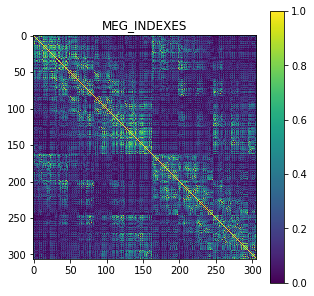

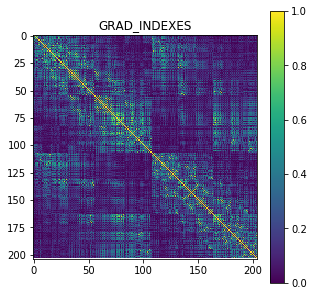

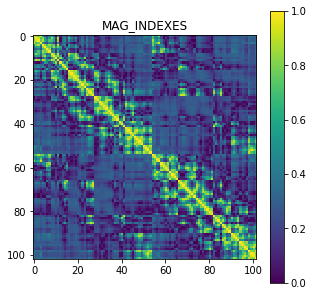

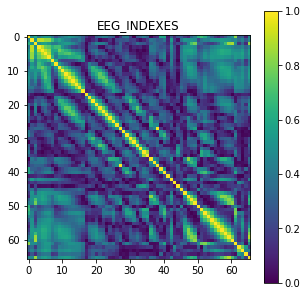

In [3]:
def visualize_corr(X, title=""):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.abs(np.corrcoef(X, rowvar=False)), vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    plt.show()
    
visualize_corr(data[:, MEG_INDEXES], "MEG_INDEXES")
visualize_corr(data[:, GRAD_INDEXES], "GRAD_INDEXES")
visualize_corr(data[:, MAG_INDEXES], "MAG_INDEXES")
visualize_corr(data[:, EEG_INDEXES], "EEG_INDEXES")

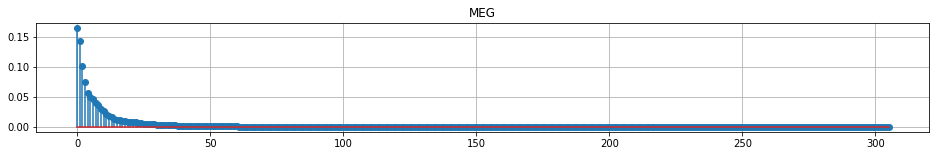

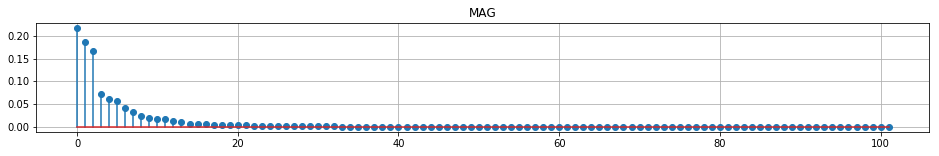

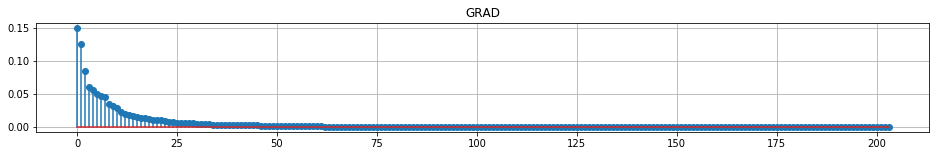

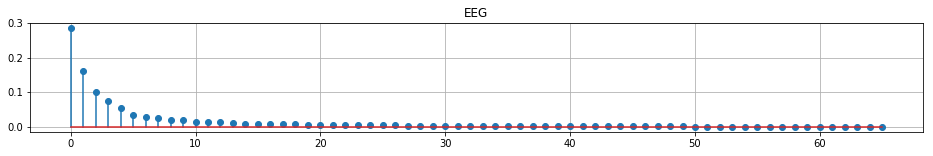

In [4]:
def plot_explained_variance_ratio(X_INDEXES, title):
    X = data[:, X_INDEXES]
    NUMBER_OF_FEATURES = X.shape[1]
    pca = sklearn.decomposition.PCA(n_components=NUMBER_OF_FEATURES)
    pca.fit(X)

    plt.figure(figsize=(16, 2))
    plt.stem(pca.explained_variance_ratio_)
    plt.grid()
    plt.title(title)
    plt.show()

plot_explained_variance_ratio(MEG_INDEXES, "MEG")
plot_explained_variance_ratio(MAG_INDEXES, "MAG")
plot_explained_variance_ratio(GRAD_INDEXES, "GRAD")
plot_explained_variance_ratio(EEG_INDEXES, "EEG")

In [5]:
FEATURES_FREQUENCIES_LIST = list(range(1, 45, 5))


def make_flat(X_3D):
    return X_3D.reshape(X_3D.shape[0], -1)


def get_narrowband_features(X, frequency=FREQUENCY, fir_taps=257, abs_values_high_pass_frequency=0.5):
    assert len(X.shape) == 2
    assert X.shape[0] > X.shape[1]

    band_filters = []
    for feature_frequency in FEATURES_FREQUENCIES_LIST:
        band_filters.append(scipy.signal.firwin(fir_taps, [0.9 * feature_frequency, 1.1 * feature_frequency], fs=frequency, pass_zero=False))

    X_output = np.zeros((X.shape[0], X.shape[1], len(FEATURES_FREQUENCIES_LIST)))
    for channel in range(X.shape[1]):
        for index, band_filter in enumerate(band_filters):
            new_feature_signal = scipy.signal.filtfilt(band_filter, [1], X[:, channel])
            X_output[:, channel, index] = new_feature_signal
    return X_output


def make_lag_3D(X_3D, lag_backward, lag_forward, decimate=1):
    # TODO: probably this code can be rewritten shorter or with use of some written methods
    assert decimate > 0
    assert lag_backward >= 0
    assert lag_forward >= 0

    output_samples = X_3D.shape[0] - lag_backward - lag_forward
    channels = X_3D.shape[1]
    feature_per_channel = X_3D.shape[2]

    features_backward = int(lag_backward / decimate)
    features_forward = int(lag_forward / decimate)
    output_features = feature_per_channel * (1 + features_forward + features_backward)

    X_output_3D = np.zeros((output_samples, channels, output_features))
    feature_index = 0
    for time_shift in range(decimate, lag_backward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward - time_shift:-lag_forward - time_shift]
        feature_index += feature_per_channel

    feature_slice = slice(feature_index, feature_index + feature_per_channel)
    X_output_3D[:, :, feature_slice] = X_3D[lag_backward:-lag_forward if lag_forward > 0 else None]  # cetntral point
    feature_index += feature_per_channel

    for time_shift in range(decimate, lag_forward + decimate, decimate):
        feature_slice = slice(feature_index, feature_index + feature_per_channel)
        X_output_3D[:, :, feature_slice] = X_3D[lag_backward + time_shift:-lag_forward + time_shift if lag_forward - time_shift > 0 else None]
        feature_index += feature_per_channel
    assert feature_index == output_features
    return X_output_3D


def get_corrs(Y, Y_predicted):
    assert Y.shape[1] == Y_predicted.shape[1]
    number_of_targets = Y.shape[1]
    return [np.corrcoef(Y[:, target_index], Y_predicted[:, target_index])[0, 1] for target_index in range(number_of_targets)]


def train_converter(X_INDEXES, Y_INDEXES, title='', mode="space", apply_ica=True):
    TRAIN_SHARE = 0.5

    X = data[:, X_INDEXES]
    Y = data[:, Y_INDEXES]

    if apply_ica:
        # Useful to faster computation
        ICA_CHANNELS = 20
        ICA = sklearn.decomposition.FastICA(n_components=ICA_CHANNELS, random_state=RANDOM_STATE)
        X = ICA.fit_transform(X)

    CHANNELS = X.shape[1]

    if mode == "space":
        X = make_flat(get_narrowband_features(X))
    elif mode == "space-time":
        LAG_BACKWARD = 25
        LAG_FOREWARD = 25
        X = make_flat(make_lag_3D(X[:, :, None], LAG_BACKWARD, LAG_FOREWARD, 1))
        Y = Y[LAG_BACKWARD:-LAG_FOREWARD, :]
    else:
        raise ValueError
    
    assert X.shape[0] == Y.shape[0], f"{X.shape[0]}!={Y.shape[0]}"
    assert X.shape[0] > X.shape[1]
    assert Y.shape[0] > Y.shape[1]

    NUMBER_OF_SAMPLES = X.shape[0]
    NUMBER_OF_FEATURES = X.shape[1]
    NUMBER_OF_TARGETS = Y.shape[1]

    X_train = X[:int(TRAIN_SHARE * NUMBER_OF_SAMPLES)]
    X_test = X[int(TRAIN_SHARE * NUMBER_OF_SAMPLES):]

    Y_train = Y[:int(TRAIN_SHARE * NUMBER_OF_SAMPLES)]
    Y_test = Y[int(TRAIN_SHARE * NUMBER_OF_SAMPLES):]

    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, Y_train)

    Y_train_predicted = model.predict(X_train)
    Y_test_predicted = model.predict(X_test)
    Y_predicted = model.predict(X)

    train_corrs = get_corrs(Y_train, Y_train_predicted)
    test_corrs = get_corrs(Y_test, Y_test_predicted)

    # Channels corr
    plt.figure(figsize=(16, 2))
    plt.stem(test_corrs)
    plt.grid()
    plt.title(f"{title} (corr mean={round(np.mean(test_corrs), 2)}; std={round(np.std(test_corrs), 2)})")
    plt.show()

    return {
        "model": model,
        "train_corrs": train_corrs,
        "test_corrs": test_corrs,
        "input_channels": CHANNELS,
        "output_channels": Y.shape[1],
        "title": title,
        "X_INDEXES": X_INDEXES,
        "Y_INDEXES": Y_INDEXES,
    }

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/conda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.ar

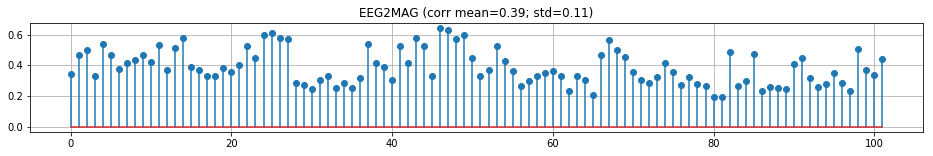

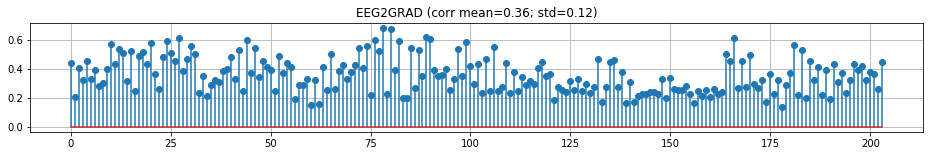

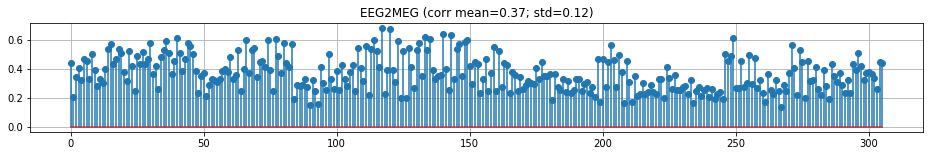

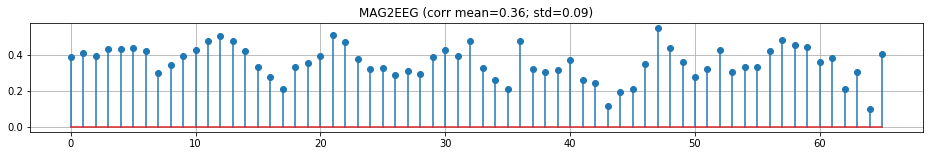

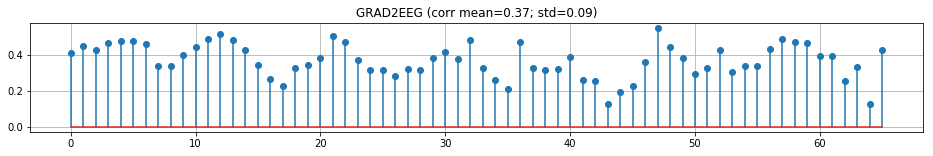

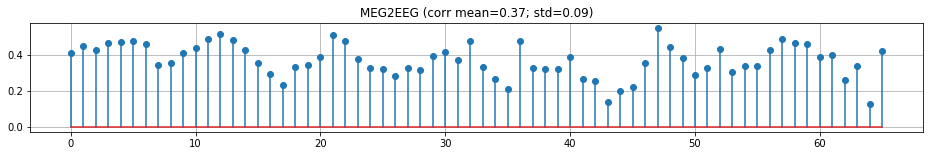

In [6]:
result_data = {}
mode = "space"

# EEG -> MEG
result_data["EEG2MAG"] = train_converter(EEG_INDEXES, MAG_INDEXES, "EEG2MAG", mode)
result_data["EEG2GRAD"] = train_converter(EEG_INDEXES, GRAD_INDEXES, "EEG2GRAD", mode)
result_data["EEG2MEG"] = train_converter(EEG_INDEXES, MEG_INDEXES, "EEG2MEG", mode)

# MEG -> EEG
result_data["MAG2EEG"] = train_converter(MAG_INDEXES, EEG_INDEXES, "MAG2EEG", mode)
result_data["GRAD2EEG"] = train_converter(GRAD_INDEXES, EEG_INDEXES, "GRAD2EEG", mode)
result_data["MEG2EEG"] = train_converter(MEG_INDEXES, EEG_INDEXES, "MEG2EEG", mode)

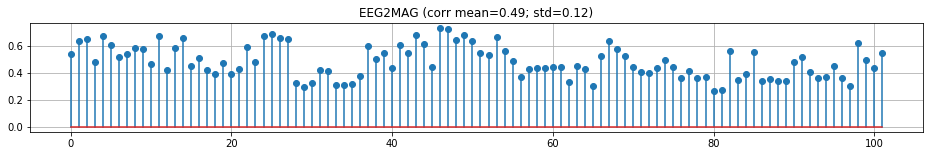

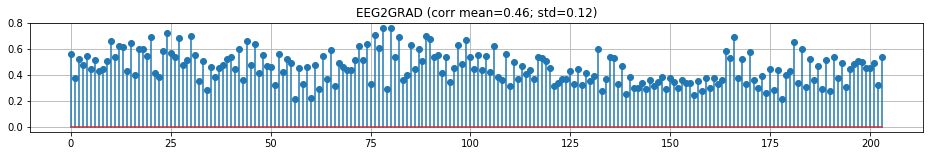

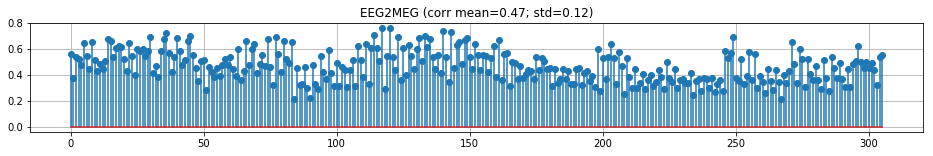

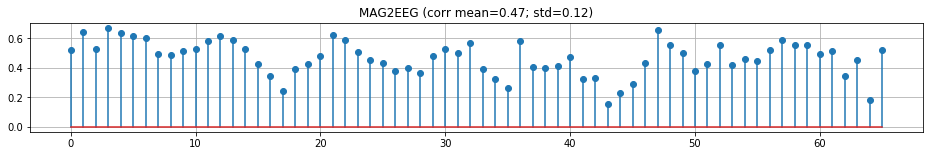

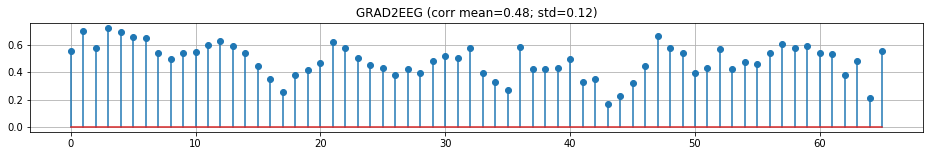

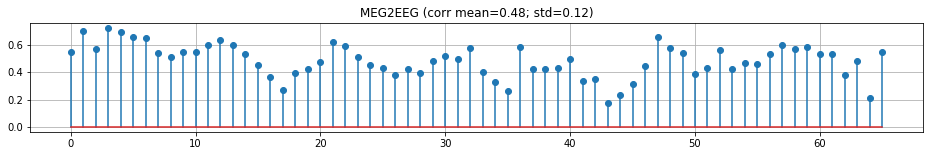

In [7]:
result_data = {}
mode = "space-time"

# EEG -> MEG
result_data["EEG2MAG"] = train_converter(EEG_INDEXES, MAG_INDEXES, "EEG2MAG", mode)
result_data["EEG2GRAD"] = train_converter(EEG_INDEXES, GRAD_INDEXES, "EEG2GRAD", mode)
result_data["EEG2MEG"] = train_converter(EEG_INDEXES, MEG_INDEXES, "EEG2MEG", mode)

# MEG -> EEG
result_data["MAG2EEG"] = train_converter(MAG_INDEXES, EEG_INDEXES, "MAG2EEG", mode)
result_data["GRAD2EEG"] = train_converter(GRAD_INDEXES, EEG_INDEXES, "GRAD2EEG", mode)
result_data["MEG2EEG"] = train_converter(MEG_INDEXES, EEG_INDEXES, "MEG2EEG", mode)